## Convolutional NN to classify govuk content to level2 taxons

Based on:
https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

## To do:
- ~~Consider grouping very small classes (especially if too small for evaluation)~~
- ~~Split data into training, validation and test to avoid overfitting validation data during hyperparamter searches & model architecture changes~~
- ~~Try learning embeddings~~--
- ~~Try changing pos_ratio~~
- Try implementing class_weights during model fit (does this do the same as the weighted binary corss entropy?)
- Work on tensorboard callbacks
- ~~Create dictionary of class indices to taxon names for viewing results~~
- ~~Check model architecture~~
- ~~consider relationship of training error to validation error - overfitting/bias?~~
- ~~train longer~~
- Try differnet max_sequence_length
- Check batch size is appropriate
- Also think about:
  - ~~regularization (e.g. dropout)~~ 
  - fine-tuning the Embedding layer

### Load requirements and data

TODO: edit requirement.txt to include only these packages and do not include tensorflow because this conflicts with tf on AWS when using on GPU.

In [1]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.utils import to_categorical, layer_utils, plot_model

from keras.layers import (Embedding, Input, Dense, Dropout, 
                          Activation, Conv1D, MaxPooling1D, Flatten, concatenate, Reshape)
from keras.models import Model, Sequential
from keras.optimizers import rmsprop
from keras.callbacks import TensorBoard, Callback, ModelCheckpoint
import keras.backend as K
from keras.losses import binary_crossentropy

from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score 
from sklearn.metrics import precision_recall_fscore_support, classification_report
from sklearn.utils import class_weight

import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

import functools

import h5py


Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


### Environmental vars

In [2]:
DATADIR=os.getenv('DATADIR')
#DATADIR='/data' #this was put in for AWS run but doesn't work locally...

## Hyperparameters

Intuition for POS_RATIO is that it penalises the prediction of zero for everything, which is attractive to the model because the multilabel y matrix is super sparse. 

Increasing POS_RATIO should penalise predicting zeros more.

In [3]:
#MAX_NB_WORDS
MAX_SEQUENCE_LENGTH =1000
EMBEDDING_DIM = 100 # keras embedding layer output_dim = Dimension of the dense embedding
P_THRESHOLD = 0.5 #Threshold for probability of being assigned to class
POS_RATIO = 0.5 #ratio of positive to negative for each class in weighted binary cross entropy loss function
NUM_WORDS=20000 #keras tokenizer num_words: None or int. Maximum number of words to work with 
#(if set, tokenization will be restricted to the top num_words most common words in the dataset).

### Read in data
Content items tagged to level 2 taxons or lower in the topic taxonomy

In [4]:
labelled_level2 = pd.read_csv(os.path.join(DATADIR, 'labelled_level2.csv.gz'), dtype=object, compression='gzip')

In [5]:
labelled_level2.sort_values('content_id').head()

,Unnamed: 0,Unnamed: 0.1,base_path,content_id,description,details,document_type,first_published_at,locale,primary_publishing_organisation,...,body,combined_text,taxon_id,taxon_base_path,taxon_name,level1taxon,level2taxon,level3taxon,level4taxon,level5taxon
57690,133980,53847.0,/government/collections/emma-jones-small-busin...,00029fa4-9b60-4285-898c-85ae8a6367f5,as small business crown representative emma is...,"{'political': False, 'body': '<div class=""govs...",document_collection,2017-01-11T10:18:00.000+00:00,en,{'title': 'Crown Commercial Service'},...,emma was appointed as small business crown rep...,emma jones - small business crown representati...,f3caf326-fe33-410f-b7f4-553f4011c81e,/government/government-spending,Government spending,Government,Government spending,NaN,NaN,NaN
30438,54663,660014.0,/government/publications/land-remediation-brin...,00037b70-5b08-44c2-bf0a-fa8eb636a60b,brochure showing uk expertise in land remediat...,"{'political': False, 'change_history': [{'note...",promotional,2015-05-11T10:41:00.000+00:00,en,{'title': 'Department for International Trade'},...,the uk was the first industrialised country in...,land remediation: bringing brownfield sites ba...,21eee04d-e702-4e7b-9fde-2f6777f1be2c,/business/business-and-enterprise,Business and enterprise,Business,Business and enterprise,NaN,NaN,NaN
125773,234347,800450.0,/government/publications/land-remediation-brin...,00037b70-5b08-44c2-bf0a-fa8eb636a60b,brochure showing uk expertise in land remediat...,"{'political': False, 'change_history': [{'note...",promotional,2015-05-11T10:41:00.000+00:00,en,{'title': 'Department for International Trade'},...,the uk was the first industrialised country in...,land remediation: bringing brownfield sites ba...,ed2ca1f7-5463-4eda-9324-b597e269e242,/business/trade-and-investment,Trade and investment,Business,Trade and investment,NaN,NaN,NaN
17256,38164,519578.0,/government/publications/land-remediation-brin...,00037b70-5b08-44c2-bf0a-fa8eb636a60b,brochure showing uk expertise in land remediat...,"{'political': False, 'change_history': [{'note...",promotional,2015-05-11T10:41:00.000+00:00,en,{'title': 'Department for International Trade'},...,the uk was the first industrialised country in...,land remediation: bringing brownfield sites ba...,a1e4659c-dc15-48be-bc4f-6c609ae061dc,/business/uk-economy,UK economy,Business,UK economy,NaN,NaN,NaN
136046,249846,102628.0,/government/statistics/steps-2-successni-stati...,00037ee5-7b5e-452d-a233-af2c134f5bce,details on the number of referrals and starts ...,"{'political': False, 'change_history': [{'note...",official_statistics,2016-11-24T09:30:13.000+00:00,en,{'title': 'Department for Communities (Norther...,...,statistics presented include details on the nu...,steps 2 success:ni statistics from october 201...,a1e624ed-e268-44ab-ac3f-4d3cb2bb8cb5,/regional-and-local-government/northern-ireland,Northern Ireland,Regional and local government,Northern Ireland,NaN,NaN,NaN


### Collapse taxons with insufficient support for predictions (will need to be manually tagged)

In [6]:
#count the number of taxons per content item into new column
labelled_level2['num_content_per_taxon'] = labelled_level2.groupby(["level2taxon"])['level2taxon'].transform("count")

In [7]:
#COLLAPSE level2taxons with too few content items into "toosmall" category
labelled_level2.loc[labelled_level2['num_content_per_taxon'] < 100, 'level2taxon'] = 'TOO_SMALL'

#### clean up any World taxons leftover despite dropping relevant doctypes

In [8]:
#COLLAPSE World level2taxons
labelled_level2.loc[labelled_level2['level1taxon'] == 'World', 'level2taxon'] = 'world_level1'

#creating categorical variable for level2taxons from values
labelled_level2['level2taxon'] = labelled_level2['level2taxon'].astype('category')

In [9]:
labelled_level2.shape

(173560, 24)

### drop news

In [10]:
labelled_level2[(labelled_level2['document_type'] == 'world_news_story')].shape

(3927, 24)

In [11]:
labelled_level2[(labelled_level2['document_type'] == 'news_story')].shape

(33214, 24)

In [12]:
nonews = labelled_level2[(labelled_level2['document_type'] != 'news_story')]

nonews = nonews[nonews['document_type'] != 'world_news_story']

In [13]:
nonews.shape

(136419, 24)

### Create dictionary mapping taxon codes to string labels

In [14]:
#Get the category numeric values (codes) and avoid zero-indexing
labels = nonews['level2taxon'].cat.codes + 1

#create dictionary of taxon category code to string label for use in model evaluation
labels_index = dict(zip((labels), nonews['level2taxon']))
labels_index

{1: 'Afghanistan',
 2: 'Armed Forces Covenant',
 3: 'Armed forces and Ministry of Defence reform',
 4: 'Armed forces support for activities in the UK',
 5: 'Arts and culture',
 6: 'Aviation',
 7: 'Biodiversity and ecosystems',
 8: 'Brexit',
 9: 'British nationals overseas',
 10: 'Business and enterprise',
 11: 'Business and the environment',
 12: 'Business tax',
 13: 'Child Benefit',
 14: 'Child maintenance reform',
 15: 'Childcare and early years',
 16: 'Civil service reform',
 17: 'Climate change and energy',
 18: 'Commercial fishing and fisheries',
 19: 'Community and society',
 20: 'Conflict in fragile states',
 21: 'Constitutional affairs',
 22: 'Consumer rights and issues',
 23: 'Counter-terrorism',
 24: 'Crime prevention',
 25: 'Cyber security',
 26: 'Dealing with HMRC',
 27: 'Driving and road transport',
 28: 'Education of disadvantaged children',
 29: 'Emergency preparation, response and recovery',
 30: 'Employing people',
 31: 'Environmental quality',
 32: 'Equality, rights a

In [15]:
print(len(labels_index))

107


### Create target/Y 

Note: when using the categorical_crossentropy loss, your targets should be in categorical format (e.g. if you have 10 classes, the target for each sample should be a 10-dimensional vector that is all-zeros expect for a 1 at the index corresponding to the class of the sample).

In multilabel learning, the joint set of binary classification tasks is expressed with label binary indicator array: each sample is one row of a 2d array of shape (n_samples, n_classes) with binary values:  
the one, i.e. the non zero elements, corresponds to the subset of labels.  
An array such as np.array([[1, 0, 0], [0, 1, 1], [0, 0, 0]]) represents label 0 in the first sample, labels 1 and 2 in the second sample, and no labels in the third sample.  
Producing multilabel data as a list of sets of labels may be more intuitive.

####  First reshape wide to get columns for each level2taxon and row number = number unique urls

In [16]:
#get a smaller copy of data for pivoting ease (think you can work from full data actually and other cols get droopedauto)

level2_reduced = nonews[['content_id', 'level2taxon', 'combined_text', 'title', 'description']].copy()

#how many level2taxons are there?
print('Number of unique level2taxons: {}'.format(level2_reduced.level2taxon.nunique()))

#count the number of taxons per content item into new column
level2_reduced['num_taxon_per_content'] = level2_reduced.groupby(["content_id"])['content_id'].transform("count")

#Add 1 because of zero-indexing to get 1-number of level2taxons as numerical targets
level2_reduced['level2taxon_code'] = level2_reduced.level2taxon.astype('category').cat.codes + 1

Number of unique level2taxons: 107


In [17]:
#how many level2taxons are there?
print('Number of unique level2taxons: {}'.format(labelled_level2.level2taxon.nunique()))

#count the number of taxons per content item into new column
labelled_level2['num_taxon_per_content'] = labelled_level2.groupby(["content_id"])['content_id'].transform("count")

#Add 1 because of zero-indexing to get 1-number of level2taxons as numerical targets
labelled_level2['level2taxon_code'] = labelled_level2.level2taxon.astype('category').cat.codes + 1

Number of unique level2taxons: 107


In [18]:
#reshape to wide per taxon and keep the combined text so indexing is consistent when splitting X from Y

multilabel = (level2_reduced.pivot_table(index=['content_id', 'combined_text', 'title', 'description' ], 
                  columns='level2taxon_code', 
                  values='num_taxon_per_content'))
print('level2reduced shape: {}'.format(level2_reduced.shape))
print('pivot table shape (no duplicates): {} '.format(multilabel.shape))
print(multilabel.head())

level2reduced shape: (136419, 7)
pivot table shape (no duplicates): (92338, 107) 
level2taxon_code                                                                                                                                                                               1    \
content_id                           combined_text                                      title                                              description                                               
00029fa4-9b60-4285-898c-85ae8a6367f5 emma jones - small business crown representativ... emma jones - small business crown representative   as small business crown representative emma is ...  NaN   
00037b70-5b08-44c2-bf0a-fa8eb636a60b land remediation: bringing brownfield sites bac... land remediation: bringing brownfield sites bac... brochure showing uk expertise in land remediati...  NaN   
00037ee5-7b5e-452d-a233-af2c134f5bce steps 2 success:ni statistics from october 2014... steps 2 success:ni statistics from oct

In [19]:
#THIS IS WHY INDEXING IS NOT ZERO-BASED
#convert the number_of_taxons_per_content values to 1, meaning there was an entry for this taxon and this content_id, 0 otherwise
binary_multilabel = multilabel.notnull().astype('int')

In [20]:
#will convert columns to an array of shape
print('Shape of Y multilabel array before train/val/test split:{}'.format(binary_multilabel[list(binary_multilabel.columns)].values.shape))

Shape of Y multilabel array before train/val/test split:(92338, 107)


In [21]:
#convert columns to an array. Each row represents a content item, each column an individual taxon
binary_multilabel = binary_multilabel[list(binary_multilabel.columns)].values
print('Example row of multilabel array {}'.format(binary_multilabel[2]))

Example row of multilabel array [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [22]:
type(binary_multilabel)

numpy.ndarray

### Format metadata/X

In [23]:
# THESE DICTS NEED TO BE CREATED IN ALL DATA, OR DOC TYPES NOT PRESENT IN TRAINING MUST BE DELETED FROM NEW
#create dictionary of document type to content_id
doctype_dict = dict(zip(nonews['content_id'], nonews['document_type']))
frstpub_dict = dict(zip(nonews['content_id'], nonews['first_published_at']))
pubapp_dict = dict(zip(nonews['content_id'], nonews['publishing_app']))
puborg_dict = dict(zip(nonews['content_id'], nonews['primary_publishing_organisation']))
len(doctype_dict)

92338

In [24]:
#the pivot table has two indices
print(multilabel.index.names)
print(multilabel.columns)
#print(multilabel.head())

['content_id', 'combined_text', 'title', 'description']
Int64Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
            ...
             98,  99, 100, 101, 102, 103, 104, 105, 106, 107],
           dtype='int64', name='level2taxon_code', length=107)


In [25]:
#extract content_id index to df
meta1 = pd.DataFrame(multilabel.index.get_level_values('content_id'))

In [26]:
#apply meta data to content
meta1['doctype'] = meta1['content_id'].map(doctype_dict).copy()
meta1['first_published_at'] = meta1['content_id'].map(frstpub_dict).copy()
meta1['pub_app'] = meta1['content_id'].map(pubapp_dict).copy()
meta1['prim_pub_org'] = meta1['content_id'].map(puborg_dict).copy()

meta1 = meta1.replace(np.nan, '', regex=True) #conver nans to empty strings for labelencoder types
meta1.head()

,content_id,doctype,first_published_at,pub_app,prim_pub_org
0,00029fa4-9b60-4285-898c-85ae8a6367f5,document_collection,2017-01-11T10:18:00.000+00:00,whitehall,{'title': 'Crown Commercial Service'}
1,00037b70-5b08-44c2-bf0a-fa8eb636a60b,promotional,2015-05-11T10:41:00.000+00:00,whitehall,{'title': 'Department for International Trade'}
2,00037ee5-7b5e-452d-a233-af2c134f5bce,official_statistics,2016-11-24T09:30:13.000+00:00,whitehall,{'title': 'Department for Communities (Norther...
3,0004c63d-ae16-432a-bb35-c0f949b1e27c,official_statistics,2016-10-20T08:30:09.000+00:00,whitehall,{'title': 'Welsh Government'}
4,0005ac76-50fe-42f1-8168-8b6fc046e40f,guidance,2017-08-02T17:29:00.000+00:00,whitehall,{'title': 'Department for Communities and Loca...


In [27]:
#encode strings as integers
#doctype
doctype_encoder = LabelEncoder()
meta1['doctype_cat'] = doctype_encoder.fit_transform(meta1['doctype']) #fit the label encoder on all data then transform on individual data sets

# print(len(meta1['doctype_cat'].unique()))
# print(meta1['doctype_cat'].unique())

# primary publishing org
pub_org_encoder = LabelEncoder()
meta1['prim_pub_org_cat'] = doctype_encoder.fit_transform(meta1['prim_pub_org']) 

# print(len(meta1['prim_pub_org_cat'].unique()))
# print(meta1['prim_pub_org_cat'].unique())

#publishing application

pub_app_encoder = LabelEncoder()
meta1['pub_app_cat'] = doctype_encoder.fit_transform(meta1['pub_app'])

# print(len(meta1['pub_app_cat'].unique()))
# print(meta1['pub_app_cat'].unique())

In [28]:
#one hot encode integers
encoded_doctype = to_categorical(meta1['doctype_cat'])
print(encoded_doctype.shape)

encoded_prim_pub_org = to_categorical(meta1['prim_pub_org_cat'])
print(encoded_prim_pub_org.shape)

encoded_pub_app = to_categorical(meta1['pub_app_cat'])
print(encoded_pub_app.shape)
type(encoded_pub_app)

(92338, 56)
(92338, 366)
(92338, 9)


numpy.ndarray

In [29]:
meta1['first_published_at'] = pd.to_datetime(meta1['first_published_at']) 

# print(meta['first_published_at'][0].Timestamp())
# for index, row in meta.iterrows():
#     row['first_published_at_ts'] = row['first_published_at'].timestamp()
#     print(row['first_published_at_ts'])

print(meta1['first_published_at'].shape)

first_published = np.array(meta1['first_published_at']).reshape(meta1['first_published_at'].shape[0], 1).copy()

print(first_published.dtype)
print(np.argmax(first_published.argmax))
#scale first published at to 0 and 1
print(first_published.shape)
type(first_published)

(92338,)
datetime64[ns]
0
(92338, 1)


numpy.ndarray

In [30]:

meta = np.concatenate((encoded_doctype, 
                           encoded_prim_pub_org, 
                           encoded_pub_app), #error when adding date...
                          axis=1)

print(meta.shape)
nb_metavars = meta.shape[1]
print(nb_metavars)
print(meta.shape)

(92338, 431)
431
(92338, 431)


### Create combined_text data/X

format our text samples and labels into tensors that can be fed into a neural network. To do this, we will rely on Keras utilities keras.preprocessing.text.Tokenizer and keras.preprocessing.sequence.pad_sequences.

In [31]:
#the pivot table has two indices
multilabel.index.names

FrozenList(['content_id', 'combined_text', 'title', 'description'])

In [32]:
#extract combined text index to array
texts = multilabel.index.get_level_values('combined_text')
texts.shape

(92338,)

### Preprocess title data

In [33]:
titles = multilabel.index.get_level_values('title')
titles.shape

(92338,)

### Preprocess description data

In [34]:
descs = multilabel.index.get_level_values('description')
descs.shape

(92338,)

### Tokenize combined text

Tokenizer = Class for vectorizing texts, or/and turning texts into sequences (=list of word indexes, where the word of rank i in the dataset (starting at 1) has index i)

In [35]:
# Bag of words method
tokenizer = Tokenizer(num_words=NUM_WORDS) #num_words: None or int. Maximum number of words to work with 
# (if set, tokenization will be restricted to the top num_words most common words in the dataset).

# apply tokenizer to our text data
tokenizer.fit_on_texts(texts)

# list of word indexes, where the word of rank i in the dataset (starting at 1) has index i
sequences = tokenizer.texts_to_sequences(texts) #yield one sequence per input text

# dictionary mapping words (str) to their rank/index (int).
word_index = tokenizer.word_index  # Only set after fit_on_texts was called.
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen= MAX_SEQUENCE_LENGTH) #MAX_SEQUENCE_LENGTH

Found 171379 unique tokens.


In [36]:
print('Shape of label tensor:', binary_multilabel.shape)
print('Shape of data tensor:', data.shape)

Shape of label tensor: (92338, 107)
Shape of data tensor: (92338, 1000)


### Tokenize title text

In [37]:
# Bag of words method
tokenizer_tit = Tokenizer(num_words=10000) #num_words: None or int. Maximum number of words to work with 
# (if set, tokenization will be restricted to the top num_words most common words in the dataset).

# apply tokenizer to our text data
tokenizer_tit.fit_on_texts(titles)

# list of word indexes, where the word of rank i in the dataset (starting at 1) has index i
sequences_tit = tokenizer_tit.texts_to_sequences(titles) #yield one sequence per input text

In [38]:
onehot_tit = tokenizer_tit.sequences_to_matrix(sequences_tit) #yield one sequence per input text

# dictionary mapping words (str) to their rank/index (int).
word_index_tit = tokenizer_tit.word_index  # Only set after fit_on_texts was called.

#NOTE THERE ARE LOTS OF NUMBERS IN HERE THAT SHOULD BE STRIPPED?

# print('Found %s unique tokens.' % len(word_index_tit))

# title_data = pad_sequences(sequences_tit, maxlen= 50) #mean/median=8 max = 47

In [39]:
onehot_tit.shape

(92338, 10000)

In [40]:

sorted(tokenizer_tit.word_counts.items(), key=lambda x:x[1], reverse=True)
#for key, value in sorted(mydict.iteritems(), key=lambda (k,v): (v,k)):
    #print "%s: %s" % (key, value)

[('and', 22819),
 ('to', 19775),
 ('of', 18825),
 ('the', 16074),
 ('for', 14865),
 ('in', 10308),
 ('on', 6770),
 ('2015', 5791),
 ('uk', 5401),
 ('2014', 5135),
 ('2016', 5092),
 ('a', 4695),
 ('report', 3632),
 ('2017', 3510),
 ('2013', 3168),
 ('government', 2971),
 ('statistics', 2866),
 ('new', 2613),
 ('england', 2585),
 ('data', 2542),
 ('information', 2221),
 ('from', 2191),
 ('review', 2050),
 ('national', 1954),
 ('at', 1938),
 ('march', 1938),
 ('tax', 1900),
 ('with', 1890),
 ('local', 1861),
 ('by', 1851),
 ('health', 1825),
 ('guidance', 1815),
 ('business', 1801),
 ('notice', 1797),
 ('2012', 1731),
 ('june', 1642),
 ('assessment', 1627),
 ('services', 1610),
 ('july', 1588),
 ('2011', 1568),
 ('april', 1542),
 ('september', 1531),
 ('statement', 1505),
 ('release', 1476),
 ('scheme', 1469),
 ('energy', 1469),
 ('foi', 1462),
 ('management', 1433),
 ('over', 1432),
 ('service', 1411),
 ('december', 1399),
 ('public', 1387),
 ('1', 1336),
 ('january', 1330),
 ('wales', 1

### Tokenize description text

In [41]:
# Bag of words method
tokenizer_desc = Tokenizer(num_words=10000) #num_words: None or int. Maximum number of words to work with 
# (if set, tokenization will be restricted to the top num_words most common words in the dataset).

# apply tokenizer to our text data
tokenizer_desc.fit_on_texts(descs)

# list of word indexes, where the word of rank i in the dataset (starting at 1) has index i
sequences_desc = tokenizer_desc.texts_to_sequences(descs) #yield one sequence per input text
onehot_desc = tokenizer_desc.sequences_to_matrix(sequences_desc) #yield one sequence per input text

# dictionary mapping words (str) to their rank/index (int).
word_index_desc = tokenizer_desc.word_index 

In [42]:
onehot_desc.shape

(92338, 10000)

### Data split
- Training data = 80%
- Development data = 10%
- Test data = 10%

In [43]:
# shuffle data and standardise indices
indices = np.arange(data.shape[0])
print(indices)
np.random.seed(0)
np.random.shuffle(indices)
print(indices)

[    0     1     2 ..., 92335 92336 92337]
[ 3348 85080 18965 ..., 42613 43567 68268]


In [44]:
data = data[indices]
metadata = meta[indices]
title_data = onehot_tit[indices]

In [45]:
desc_data = onehot_desc[indices]
timedata = first_published[indices]


labels = binary_multilabel[indices]

In [46]:
nb_test_samples = int(0.1 * data.shape[0]) #validation split
print('nb_test samples:', nb_test_samples)

nb_dev_samples = int(0.2 * data.shape[0]) #validation split
print('nb_dev samples:', nb_dev_samples)

nb_training_samples = int(0.8 * data.shape[0]) #validation split
print('nb_training samples:', nb_training_samples)

nb_test samples: 9233
nb_dev samples: 18467
nb_training samples: 73870


In [47]:
x_train = data[:-nb_dev_samples]
print('Shape of x_train:', x_train.shape)

metax_train = metadata[:-nb_dev_samples]
print('Shape of metax_train:', metax_train.shape)

titlex_train = title_data[:-nb_dev_samples]
print('Shape of titlex_train:', titlex_train.shape)

descx_train = desc_data[:-nb_dev_samples]
print('Shape of descx_train:', descx_train.shape)

datex_train = timedata[:-nb_dev_samples]
print('Shape of datex_train:', datex_train.shape)

y_train = labels[:-nb_dev_samples]
print('Shape of y_train:', y_train.shape)

Shape of x_train: (73871, 1000)
Shape of metax_train: (73871, 431)
Shape of titlex_train: (73871, 10000)
Shape of descx_train: (73871, 10000)
Shape of datex_train: (73871, 1)
Shape of y_train: (73871, 107)


In [48]:
x_dev = data[-nb_dev_samples:-nb_test_samples]
print('Shape of x_dev:', x_dev.shape)

metax_dev = metadata[-nb_dev_samples:-nb_test_samples]
print('Shape of metax_dev:', metax_dev.shape)

titlex_dev = title_data[-nb_dev_samples:-nb_test_samples]
print('Shape of titlex_dev:', titlex_dev.shape)

descx_dev = desc_data[-nb_dev_samples:-nb_test_samples]
print('Shape of descx_dev:', descx_dev.shape)

datex_dev = timedata[-nb_dev_samples:-nb_test_samples]
print('Shape of metax_dev:', datex_dev.shape)

y_dev = labels[-nb_dev_samples:-nb_test_samples]
print('Shape of y_dev:', y_dev.shape)

Shape of x_dev: (9234, 1000)
Shape of metax_dev: (9234, 431)
Shape of titlex_dev: (9234, 10000)
Shape of descx_dev: (9234, 10000)
Shape of metax_dev: (9234, 1)
Shape of y_dev: (9234, 107)


In [49]:
x_test = data[-nb_test_samples:]
print('Shape of x_test:', x_test.shape)

metax_test = metadata[-nb_test_samples:]
print('Shape of metax_test:', metax_test.shape)

titlex_test = title_data[-nb_test_samples:]
print('Shape of titlex_test:', titlex_test.shape)

descx_test = desc_data[-nb_test_samples:]
print('Shape of descx_test:', descx_test.shape)

datex_test = timedata[-nb_test_samples:]
print('Shape of datex_test:', datex_test.shape)

y_test = labels[-nb_test_samples:]
print('Shape of y_test:', y_test.shape)

Shape of x_test: (9233, 1000)
Shape of metax_test: (9233, 431)
Shape of titlex_test: (9233, 10000)
Shape of descx_test: (9233, 10000)
Shape of datex_test: (9233, 1)
Shape of y_test: (9233, 107)


### preparing the Embedding layer

NB stopwords haven't been removed yet...

In [50]:
embedding_layer = Embedding(len(word_index) + 1, 
                            EMBEDDING_DIM, 
                            input_length=MAX_SEQUENCE_LENGTH)

An Embedding layer should be fed sequences of integers, i.e. a 2D input of shape (samples, indices). These input sequences should be padded so that they all have the same length in a batch of input data (although an Embedding layer is capable of processing sequence of heterogenous length, if you don't pass an explicit input_length argument to the layer).

All that the Embedding layer does is to map the integer inputs to the vectors found at the corresponding index in the embedding matrix, i.e. the sequence [1, 2] would be converted to [embeddings[1], embeddings[2]]. This means that the output of the Embedding layer will be a 3D tensor of shape (samples, sequence_length, embedding_dim).

### Estimate class weights for unbalanced datasets.
paramter to model.fit = __class_weight__: Optional dictionary mapping class indices (integers) to a weight (float) value, used for weighting the loss function (during training only). This can be useful to tell the model to "pay more attention" to samples from an under-represented class.

Implement class_weight from sklearn:

- Import the module 

`from sklearn.utils import class_weight`
- calculate the class weight, If ‘balanced’, class weights will be given by n_samples / (n_classes * np.bincount(y)):

`class_weight = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)`

- change it to a dict in order to work with Keras.

`class_weight_dict = dict(enumerate(class_weight))`

- Add to model fitting

`model.fit(X_train, y_train, class_weight=class_weight)`

In [51]:
# class_weight = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
# class_weight_dict = dict(enumerate(class_weight))

### Custom loss function

In [52]:
class WeightedBinaryCrossEntropy(object):

    def __init__(self, pos_ratio):
        neg_ratio = 1. - pos_ratio
        #self.pos_ratio = tf.constant(pos_ratio, tf.float32)
        self.pos_ratio = pos_ratio
        #self.weights = tf.constant(neg_ratio / pos_ratio, tf.float32)
        self.weights = neg_ratio / pos_ratio
        self.__name__ = "weighted_binary_crossentropy({0})".format(pos_ratio)

    def __call__(self, y_true, y_pred):
        return self.weighted_binary_crossentropy(y_true, y_pred)

    def weighted_binary_crossentropy(self, y_true, y_pred):
            # Transform to logits
            epsilon = tf.convert_to_tensor(K.common._EPSILON, y_pred.dtype.base_dtype)
            y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)
            y_pred = tf.log(y_pred / (1 - y_pred))

            cost = tf.nn.weighted_cross_entropy_with_logits(y_true, y_pred, self.weights)
            return K.mean(cost * self.pos_ratio, axis=-1)
    
y_true_arr = np.array([0,1,0,1], dtype="float32")
y_pred_arr = np.array([0,0,1,1], dtype="float32")
y_true = tf.constant(y_true_arr)
y_pred = tf.constant(y_pred_arr)

with tf.Session().as_default(): 
    print(WeightedBinaryCrossEntropy(0.5)(y_true, y_pred).eval())
    print(binary_crossentropy(y_true, y_pred).eval())


4.00756
8.01512


### difficulty getting global precision/recall metrics . CAUTION interpreting monitoring metrics
fcholltet: "Basically these are all global metrics that were approximated
batch-wise, which is more misleading than helpful. This was mentioned in
the docs but it's much cleaner to remove them altogether. It was a mistake
to merge them in the first place."

In [53]:
def f1(y_true, y_pred):
    """Use Recall  and precision metrics to calculate harmonic mean (F1 score).

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1 = 2*((precision*recall)/(precision+recall))
    
    return f1

## Training a 1D convnet

### 1. Create model

In [54]:
NB_CLASSES = y_train.shape[1]
NB_METAVARS = metax_train.shape[1]



sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32', name='wordindex') #MAX_SEQUENCE_LENGTH
embedded_sequences = embedding_layer(sequence_input)
x = Dropout(0.2, name = 'dropout_embedded')(embedded_sequences)

x = Conv1D(128, 5, activation='relu', name = 'conv0')(x)

x = MaxPooling1D(5, name = 'max_pool0')(x)

x = Dropout(0.5, name = 'dropout0')(x)

x = Conv1D(128, 5, activation='relu', name = 'conv1')(x)

x = MaxPooling1D(5 , name = 'max_pool1')(x)

x = Conv1D(128, 5, activation='relu', name = 'conv2')(x)

x = MaxPooling1D(35, name = 'global_max_pool')(x)  # global max pooling

x = Flatten()(x) #reduce dimensions from 3 to 2; convert to vector + FULLYCONNECTED

meta_input = Input(shape=(NB_METAVARS,), name='meta')
meta_hidden = Dense(128, activation='relu', name = 'hidden_meta')(meta_input)
meta_hidden = Dropout(0.2, name = 'dropout_meta')(meta_hidden)


title_input = Input(shape=(titlex_train.shape[1],), name='titles')
title_hidden = Dense(128, activation='relu', name = 'hidden_title')(title_input)
title_hidden = Dropout(0.2, name = 'dropout_title')(title_hidden)

desc_input = Input(shape=(descx_train.shape[1],), name='descs')
desc_hidden = Dense(128, activation='relu', name = 'hidden_desc')(desc_input)
desc_hidden = Dropout(0.2, name = 'dropout_desc')(desc_hidden)

concatenated = concatenate([meta_hidden, title_hidden, desc_hidden, x])

x = Dense(400, activation='relu', name = 'fully_connected0')(concatenated)

x = Dropout(0.2, name = 'dropout1')(x)

x = Dense(NB_CLASSES, activation='sigmoid', name = 'fully_connected1')(x)

# # The Model class turns an input tensor and output tensor into a model
# This creates Keras model instance, will use this instance to train/test the model.
model = Model(inputs=[meta_input, title_input, desc_input, sequence_input], outputs=x)

### 2. Compile model

In [55]:
model.compile(loss=WeightedBinaryCrossEntropy(POS_RATIO),
              optimizer='rmsprop',
              metrics=['binary_accuracy', f1])

Metric values are recorded at the end of each epoch on the training dataset. If a validation dataset is also provided, then the metric recorded is also calculated for the validation dataset.

All metrics are reported in verbose output and in the history object returned from calling the fit() function. In both cases, the name of the metric function is used as the key for the metric values. In the case of metrics for the validation dataset, the “val_” prefix is added to the key.

You have now built a function to describe your model. To train and test this model, there are four steps in Keras:
1. Create the model by calling the function above
2. Compile the model by calling `model.compile(optimizer = "...", loss = "...", metrics = ["accuracy"])`
3. Train the model on train data by calling `model.fit(x = ..., y = ..., epochs = ..., batch_size = ...)`
4. Test the model on test data by calling `model.evaluate(x = ..., y = ...)`

If you want to know more about `model.compile()`, `model.fit()`, `model.evaluate()` and their arguments, refer to the official [Keras documentation](https://keras.io/models/model/).


In [56]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
wordindex (InputLayer)          (None, 1000)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1000, 100)    17138000    wordindex[0][0]                  
__________________________________________________________________________________________________
dropout_embedded (Dropout)      (None, 1000, 100)    0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv0 (Conv1D)                  (None, 996, 128)     64128       dropout_embedded[0][0]           
__________________________________________________________________________________________________
max_pool0 

### Tensorboard callbacks /metrics /monitor training

<span style="color:red"> **Size of these files is killing storage during training. Is it histograms?**</span>

In [57]:
tb = TensorBoard(log_dir='./learn_embedding_logs', histogram_freq=1, write_graph=True, write_images=False)

In [58]:
CHECKPOINT_PATH = os.path.join(DATADIR, 'model_checkpoint.hdf5')

cp = ModelCheckpoint(
                     filepath = CHECKPOINT_PATH, 
                     monitor='val_loss', 
                     verbose=0, 
                     save_best_only=False, 
                     save_weights_only=False, 
                     mode='auto', 
                     period=1
                    )

In [59]:
# class Metrics(Callback):
#     def on_train_begin(self, logs={}):
#         self.val_f1s = []
#         self.val_recalls = []
#         self.val_precisions = []
 
#     def on_epoch_end(self, epoch, logs={}):
#         val_predict = (np.asarray(self.model.predict(self.model.validation_data[0]))).round()
#         val_targ = self.model.validation_data[1]
        
#         self.val_f1s.append(f1_score(val_targ, val_predict, average='micro'))
#         self.val_recalls.append(recall_score(val_targ, val_predict))
#         self.val_precisions.append(precision_score(val_targ, val_predict))
#         print("- val_f1: %f — val_precision: %f — val_recall %f" 
#                 %(f1_score(val_targ, val_predict, average='micro'), 
#                   precision_score(val_targ, val_predict),
#                    recall_score(val_targ, val_predict)))
#         return
 
# metrics = Metrics()

In [60]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2)
#model.fit(x, y, validation_split=0.2, callbacks=[early_stopping])

### 3. Train model

In [61]:
# metrics callback causes: CCCCCCR55555555511155
# So disable for now

history = model.fit(
    {'meta': metax_train, 'titles': titlex_train, 'descs': descx_train, 'wordindex': x_train},
    y_train, 
    validation_data=([metax_dev, titlex_dev, descx_dev, x_dev], y_dev), 
    epochs=10, batch_size=128, callbacks=[early_stopping]
)

Train on 73871 samples, validate on 9234 samples
Epoch 1/10
73871/73871 [==============================] - 72s 975us/step - loss: 0.0188 - binary_accuracy: 0.9896 - f1: nan - val_loss: 0.0105 - val_binary_accuracy: 0.9931 - val_f1: 0.7027
Epoch 2/10
73871/73871 [==============================] - 69s 933us/step - loss: 0.0089 - binary_accuracy: 0.9940 - f1: 0.7432 - val_loss: 0.0088 - val_binary_accuracy: 0.9940 - val_f1: 0.7528
Epoch 3/10
73871/73871 [==============================] - 69s 933us/step - loss: 0.0073 - binary_accuracy: 0.9951 - f1: 0.7966 - val_loss: 0.0085 - val_binary_accuracy: 0.9943 - val_f1: 0.7678
Epoch 4/10
73871/73871 [==============================] - 69s 933us/step - loss: 0.0063 - binary_accuracy: 0.9957 - f1: 0.8276 - val_loss: 0.0083 - val_binary_accuracy: 0.9945 - val_f1: 0.7770
Epoch 5/10
73871/73871 [==============================] - 68s 927us/step - loss: 0.0056 - binary_accuracy: 0.9962 - f1: 0.8498 - val_loss: 0.0082 - val_binary_accuracy: 0.9946 - val_

In [62]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_binary_accuracy', 'val_f1', 'loss', 'binary_accuracy', 'f1'])

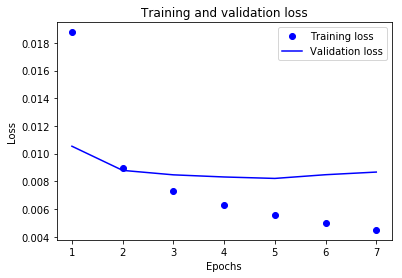

In [63]:
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, 8)

plt.plot(epochs, loss_values, 'bo', label='Training loss')           
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')      
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

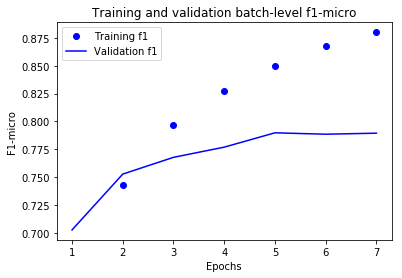

In [64]:
plt.clf()    

f1_values = history_dict['f1']
val_f1_values = history_dict['val_f1']

plt.plot(epochs, f1_values, 'bo', label='Training f1')
plt.plot(epochs, val_f1_values, 'b', label='Validation f1')
plt.title('Training and validation batch-level f1-micro')
plt.xlabel('Epochs')
plt.ylabel('F1-micro')
plt.legend()

plt.show()

### Evaluate model

#### Training metrics

In [65]:
y_prob = model.predict([metax_train, titlex_train, descx_train, x_train])

In [66]:
y_prob.shape

(73871, 107)

In [67]:
y_pred = y_prob.copy()
y_pred[y_pred>=P_THRESHOLD] = 1
y_pred[y_pred<P_THRESHOLD] = 0

In [68]:
f1_score(y_train, y_pred, average='micro')

0.92260658914728677

In [69]:
#average= None, the scores for each class are returned.
precision_recall_fscore_support(y_train, y_pred, average=None, sample_weight=None)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(array([ 0.93478261,  1.        ,  0.76829268,  0.        ,  0.93079585,
         0.93193717,  0.95333333,  0.89516129,  0.90763052,  0.95631202,
         0.9185879 ,  0.95110858,  0.98850575,  0.93506494,  0.98113208,
         0.97029703,  0.93300111,  0.935     ,  0.94218685,  0.91666667,
         0.95192308,  0.95863309,  0.94927536,  0.89830508,  0.97761194,
         0.89738146,  0.96424581,  0.93023256,  0.95538312,  0.95505618,
         0.89967638,  0.93539519,  0.97260274,  0.88218391,  0.9339207 ,
         0.97691373,  0.92145515,  0.93607595,  0.95774648,  0.98784722,
         0.94169633,  0.9031477 ,  0.98461538,  0.94230049,  0.96213992,
         0.90675991,  0.91743119,  0.96168109,  0.97003929,  0.91044776,
         0.81578947,  0.97115385,  0.97196262,  1.        ,  0.94153337,
         0.9186747 ,  0.88950276,  0.89690722,  0.89915966,  0.97818792,
         0.97234043,  0.89130435,  0.765625  ,  0.87601297,  1.        ,
         0.9111349 ,  0.94179894,  0.91122715,  0.9

In [ ]:
a = precision_recall_fscore_support(y_train, y_pred, average=None, sample_weight=None)

In [ ]:
pd.DataFrame(list(a))

In [ ]:
f1_byclass = pd.DataFrame((a)[2], columns=['f1'])


In [ ]:
support_byclass = pd.DataFrame((a)[3], columns=['support'])

f1_byclass = pd.merge(
    left=f1_byclass, 
    right=support_byclass, 
    left_index=True,
    right_index=True,
    how='outer', 
    validate='one_to_one'
)

f1_byclass['index_col'] = f1_byclass.index

In [ ]:
f1_byclass['level2taxon'] = f1_byclass['index_col'].map(labels_index).copy()

In [ ]:
print("At p_threshold of {}, there were {} out of {} ({})% taxons with auto-tagged content in the training data"
      .format(P_THRESHOLD, 
              f1_byclass.loc[f1_byclass['f1'] > 0].shape[0], 
              y_pred.shape[1], 
              (f1_byclass.loc[f1_byclass['f1'] > 0].shape[0]/y_pred.shape[1])*100 ))

In [ ]:
no_auto_content = f1_byclass.loc[f1_byclass['f1'] == 0]
no_auto_content = no_auto_content.set_index('level2taxon')

In [ ]:
no_auto_content['support'].sort_values().plot( kind = 'barh', figsize=(20, 20))

In [ ]:
classes_predictedto = f1_byclass.loc[f1_byclass['f1'] > 0]
classes_predictedto = classes_predictedto.set_index('level2taxon') 

In [ ]:
classes_predictedto.plot.scatter(x='support', y='f1', figsize=(20, 10), xticks=np.arange(0, 9700, 100))

In [ ]:
classes_predictedto['f1'].sort_values().plot( kind = 'barh', figsize=(20, 20))

In [ ]:
#Calculate globally by counting the total true positives, false negatives and false positives.
precision_recall_fscore_support(y_train, y_pred, average='micro', sample_weight=None) 

In [ ]:
#Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account
precision_recall_fscore_support(y_train, y_pred, average='macro', sample_weight=None)

#### Development set metrics

In [70]:
y_pred_dev = model.predict([metax_dev, titlex_dev, descx_dev, x_dev])

In [71]:
y_pred_dev[y_pred_dev>=P_THRESHOLD] = 1
y_pred_dev[y_pred_dev<P_THRESHOLD] = 0

In [72]:
#average= None, the scores for each class are returned.
precision_recall_fscore_support(y_dev, y_pred_dev, average=None, sample_weight=None)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(array([ 1.        ,  1.        ,  0.58333333,  0.        ,  0.79661017,
         0.88235294,  0.76666667,  0.85714286,  0.83760684,  0.84930032,
         0.64971751,  0.82520325,  0.92307692,  1.        ,  1.        ,
         0.8125    ,  0.83878505,  0.63636364,  0.80427046,  0.        ,
         0.83333333,  0.76666667,  0.76923077,  0.52941176,  0.95      ,
         0.69189189,  0.86486486,  0.25      ,  0.87128713,  1.        ,
         0.73076923,  0.76433121,  0.8       ,  0.71428571,  0.91176471,
         0.89      ,  0.81481481,  0.70093458,  0.78571429,  0.92405063,
         0.84771574,  0.67096774,  1.        ,  0.84045584,  0.83274021,
         0.66037736,  0.65384615,  0.83333333,  0.94117647,  0.5       ,
         0.54545455,  0.875     ,  0.72727273,  1.        ,  0.86633663,
         0.85714286,  0.58823529,  0.8       ,  0.92307692,  0.90410959,
         0.96      ,  0.75      ,  0.64285714,  0.8013245 ,  0.        ,
         0.78846154,  0.89320388,  0.76190476,  0.9

In [73]:
#Calculate globally by counting the total true positives, false negatives and false positives.
precision_recall_fscore_support(y_dev, y_pred_dev, average='micro', sample_weight=None) 

(0.82756612876393276, 0.75479857370457482, 0.78950918541443482, None)

In [ ]:
#Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account
precision_recall_fscore_support(y_dev, y_pred_dev, average='macro', sample_weight=None)

## Tag unlabelled content

In [ ]:
def get_predictions(new_texts, df, level1taxon=False):
    #process data for model input
    
    new_sequences = tokenizer.texts_to_sequences(new_texts) #yield one sequence per input text

    new_word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(new_word_index))

    x_new = pad_sequences(new_sequences, maxlen= MAX_SEQUENCE_LENGTH) #MAX_SEQUENCE_LENGTH
    
    print('Shape of untagged tensor:', x_new.shape)
    
    #predict tag for untagged data
    y_pred_new = model.predict(x_new)
    
    #get model output into pandas & get a column to track index for later merge
    y_pred_new = pd.DataFrame(y_pred_new)
    y_pred_new['index_col'] = y_pred_new.index
    
    #Make long by taxon so easier to filter rows and examine effect of p_threshold
    y_pred_new = pd.melt(y_pred_new, id_vars=['index_col'],
                             var_name='level2taxon_code', value_name='probability')
    
    #get taxon names
    y_pred_new['level2taxon'] = y_pred_new['level2taxon_code'].map(labels_index)
    
    if level1taxon==False:
        #get the info about the content
        new_info = df[[ 'base_path', 'content_id', 'title', 'description', 
                   'document_type', 'publishing_app', 'locale']]
    else:
        new_info = df[[ 'base_path', 'content_id', 'title', 'description', 
                   'document_type', 'publishing_app', 'locale', 'level1taxon']]
    
    
    #merge content info with taxon prediction
    pred_new = pd.merge(
    left=new_info, 
    right=y_pred_new, 
    left_index=True,
    right_on='index_col',
    how='outer'
    )
    
    #drop the cols needed for mergingin and naming
    pred_new.drop(['index_col'], axis=1, inplace = True)
    
    #keep only rows where prob of taxon > 0.5
    
    
    return pred_new #.loc[pred_new['probability'] > P_THRESHOLD] #only return rows/samples where probability is hihger than threshold
    

### Untagged

In [ ]:
#read in untagged content
untagged_raw = pd.read_csv(os.path.join(DATADIR, 'untagged_content.csv.gz'), dtype=object, compression='gzip')

In [ ]:
untagged_raw.head()

In [ ]:
new_texts = untagged_raw['combined_text']

In [ ]:
pred_untagged = get_predictions(new_texts, untagged_raw)

In [ ]:
#data is long by taxon
print('Number of unique content items: {}'.format(pred_untagged.content_id.nunique()))
print('Number of content items tagged to taxons with more than p_threshold: {}'.format(pred_untagged.shape))

In [ ]:
pred_untagged.loc[(pred_untagged['probability'] > 0.65) & (pred_untagged['probability'] < 0.85)].sort_values(by='probability', ascending=False)

In [ ]:
#write to csv
pred_untagged.to_csv(os.path.join(DATADIR, 'predictions_for_untagged_data_trainingdatatok.csv'), index=False)

In [ ]:
# apply tokenizer to our text data
tokenizer.fit_on_texts(new_texts)

pred_untagged_refit_tok = get_predictions(new_texts, untagged_raw)


In [ ]:
#write to csv
pred_untagged_refit_tok.to_csv(os.path.join(DATADIR, 'predictions_for_untagged_data_refittok.csv'), index=False)

### New data (untagged + old taxons)

old_taxons data has no combined text. This needs fixing in the data pipeline before being able to use these data for predictions

In [ ]:
#read in untagged content
new_raw = pd.read_csv(os.path.join(DATADIR, 'new_content.csv'), dtype=object)

In [ ]:
new_raw.shape

In [ ]:
type(new_raw['combined_text'][0])

In [ ]:
new_raw['combined_text'][0]

In [ ]:
len(new_raw[new_raw['combined_text'].isna()])

In [ ]:
(new_raw.loc[(new_raw['combined_text'].isna()) & (new_raw['untagged_type'] == 'old_taxons')]).shape

In [ ]:
new_raw[new_raw.untagged_type == 'old_taxons']

In [ ]:
#make a copy so you can edit data without needed to read in each time
new_df = new_raw.copy(deep=True)

In [ ]:
pred_new = get_predictions(new_df )

In [ ]:
#keep only rows where prob of taxon > 0.5
pred_new = pred_new.loc[pred_new['probability'] > 0.5]

In [ ]:
#write to csv
pred_new.to_csv(os.path.join(DATADIR, 'predictions_for_new_data.csv'), index=False)

### Labelled at level1only

In [ ]:
labelled_level1 = pd.read_csv(os.path.join(DATADIR, 'labelled_level1.csv'), dtype=object)

In [ ]:
level1_texts = labelled_level1['combined_text']

In [ ]:
#reset tokenizer to training data texts
tokenizer.fit_on_texts(texts)

In [ ]:
pred_labelled_level1 = get_predictions(level1_texts, labelled_level1, level1taxon=True)

In [ ]:
pred_labelled_level1.sort_values(by='probability', ascending=False)

In [ ]:
#write to csv
pred_labelled_level1.to_csv(os.path.join(DATADIR, 'predictions_for_level1only.csv'), index=False)

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='cnn.png', show_shapes=True)